In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer



# download the set of stop words
nltk.download('stopwords')
nltk.download('wordnet')

# create a set of stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/yyy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yyy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Dataset exploration

## Load dataset

In [115]:
# Load the data and select a random sample of 2500 rows
# data = pd.read_csv('./data/Train_rev1_subset.csv').sample(2500, random_state=420)
# data.to_csv('./data/Train_rev1_subset.csv', index=False)
data = pd.read_csv('./data/Train_rev1_subset.csv')

In [116]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
243764,72691668,SEO Executive,"SEO Executive **** **** Nottingham, Nottingha...","Nottingham,Nottinghamshire",UK,NaN,permanent,EMBS People Transfer,IT Jobs,18k - 20k per year,19000,jobsite.co.uk
243944,72692127,Student Support Assistant,"Westerham Road, Westerham, Kent TN**** ****QN ...",Westerham,Westerham,NaN,NaN,Print Upsell S X Post,Healthcare & Nursing Jobs,7.60 per hour,14592,jobsite.co.uk
212921,72233374,iOS Mobile Applications Developer,Mobile iOS Developer Our vision here is to be...,Welwyn Garden City Hertfordshire South East,UK,NaN,permanent,Modis,Retail Jobs,45000 - 55000 per annum + Excellent Benefits,50000,totaljobs.com
174253,71433541,Office Manager,Office Manager – Property Company A reputable ...,Bath Avon South West,UK,NaN,permanent,Appoint Personnel,Admin Jobs,"From 18,000 to 23,000 per annum 18,000 basic +...",20500,totaljobs.com
22458,67393718,Music Teacher,My client is a school located in Croydon who a...,Surrey,Surrey,full_time,contract,CAREER TEACHERS,Teaching Jobs,120 - 180 per day,36000,jobs.guardian.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
157757,71122006,"Graduate Web Developer (PHP, DRUPAL)",Leading new media firm with offices in London ...,Salisbury,Salisbury,NaN,permanent,NaN,Admin Jobs,20k - 25k,22500,simplyofficejobs.co.uk
215109,72241501,PART TIME TRAVEL CONSULTANT,PART TIME TRAVEL CONSULTANT Our Client is a lu...,Oxfordshire South East,Oxfordshire,NaN,contract,Prospects4Leisure Travel,Travel Jobs,"18,000 per annum + Commission",18000,totaljobs.com
183025,71620202,Pensions Administration Specialist,Pensions Administration Specialist Surrey/Suss...,Surrey,Surrey,NaN,permanent,Branwell Ford Associates,Accounting & Finance Jobs,GBP25000 - 30000 per annum,27500,professionalpensionsjobs.com
190426,71744831,Fully Qualified Spanish Teacher,Spanish Teachers Excellent Secondary School in...,Coventry,Coventry,NaN,NaN,Aspire People,Teaching Jobs,105 - 140 per day,29400,MyUkJobs


## Explore the dataset

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 243764 to 54210
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  2500 non-null   int64 
 1   Title               2500 non-null   object
 2   FullDescription     2500 non-null   object
 3   LocationRaw         2500 non-null   object
 4   LocationNormalized  2500 non-null   object
 5   ContractType        634 non-null    object
 6   ContractTime        1832 non-null   object
 7   Company             2168 non-null   object
 8   Category            2500 non-null   object
 9   SalaryRaw           2500 non-null   object
 10  SalaryNormalized    2500 non-null   int64 
 11  SourceName          2500 non-null   object
dtypes: int64(2), object(10)
memory usage: 253.9+ KB


In [118]:
# look at a subset of data

print(data['FullDescription'].iloc[0])
print(data['FullDescription'].iloc[1])
print(data['FullDescription'].iloc[2])

SEO Executive ****  **** Nottingham, Nottinghamshire Hillarys have an incredible story, established 40 years ago and now with **** staff plus **** Advisors throughout the UK, a 100 million turnover and unprecedented market leaders in the Blinds, Shutters Curtains market. Their Marketing Department is made of up **** talented Marketing professionals covering Digital / eCommerce, Direct Mail, Communications and PR/Exhibitions with an impressive annual budget of c 19 million. Hillarys are looking to insource their SEO and are looking for an SEO Executive to work across their two rapidly growing ecommerce brands. They will be reporting to the SEO Manager and helping to dive forward the natural rankings. The role outline is as follows: The role will involve: Collaboration with inhouse content creation team Defining off page content strategy Implement effective link building strategy via blogger outreach and Monitor and report the impact of all SEO activity using various reporting tools In o

## Data pre-processing

### Feature engineering

In [119]:
# find the 75th percentile of the salary
salary_75th_percentile = data['SalaryNormalized'].quantile(0.75)
data['SalaryLevel'] = np.where(data['SalaryNormalized'] > salary_75th_percentile, 'high', 'low')

### Data cleaning

In [120]:
# keep only the FullDescription and SalaryLevel columns
data = data[['FullDescription', 'SalaryLevel']]

# create a lemmatizer
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    '''
    This function cleans the text by removing non-alphabetic characters,
    making all text lowercase, tokenizing the text, removing stop words,
    and lemmatizing the words.
    '''

    # remove non-alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text)
    # make all text lowercase
    text = text.lower()
    # tokenize the text
    words = text.split()
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]
    # join the words back together
    text = ' '.join(words)
    return text

# apply the function to the FullDescription column
data['FullDescription'] = data['FullDescription'].apply(clean_text)

/var/folders/_t/yhfwr7zs235_z88czy6gmp2m0000gn/T/ipykernel_95406/333714182.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FullDescription'] = data['FullDescription'].apply(clean_text)


In [121]:
# check again to see if the data has been cleaned

print(data['FullDescription'].iloc[0])
print(data['FullDescription'].iloc[1])
print(data['FullDescription'].iloc[2])

seo executive nottingham nottinghamshire hillary incredible story established year ago staff plus advisor throughout uk million turnover unprecedented market leader blind shutter curtain market marketing department made talented marketing professional covering digital ecommerce direct mail communication pr exhibition impressive annual budget c million hillary looking insource seo looking seo executive work across two rapidly growing ecommerce brand reporting seo manager helping dive forward natural ranking role outline follows role involve collaboration inhouse content creation team defining page content strategy implement effective link building strategy via blogger outreach monitor report impact seo activity using various reporting tool order considered need following qualification experience passion preferably one year hand seo experience experience increase ranking link building page seo experience google analytics knowledge recent google update good level english skill apply role 

In [173]:
# create a CountVectorizer object
vectorizer = CountVectorizer(max_features=4000)

# fit and transform the data
X = vectorizer.fit_transform(data['FullDescription']).toarray()

# create a DataFrame from the document-term matrix
X = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

# check the DataFrame
X

,aa,aat,abap,aberdeen,ability,able,abreast,abroad,absence,absolute,...,year,yearly,yes,yet,york,yorkshire,young,youth,yr,zend
0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2496,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2497,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train test split

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, data['SalaryLevel'], test_size=0.2, random_state=42)

# Q1

## Naive Bayes model

In [175]:
# use naive bayes classifier
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy


# combine the features and labels
def combine_features_and_labels(X,y):
    '''
    This function combines the features and labels into a list of tuples.
    '''
    combined = []
    for i in range(len(X)):
        features = X.iloc[i].to_dict()
        label = y.iloc[i]
        combined.append((features, label))
    return combined


training_set = combine_features_and_labels(X_train, y_train)
test_set = combine_features_and_labels(X_test, y_test)

# train the classifier
classifier = NaiveBayesClassifier.train(training_set)

# check the accuracy of the classifier
print("Model accuracy is: ",accuracy(classifier, test_set))

Model accuracy is:  0.772


     |   h     |
     |   i   l |
     |   g   o |
     |   h   w |
-----+---------+
high | <65> 50 |
 low |  64<321>|
-----+---------+
(row = reference; col = test)



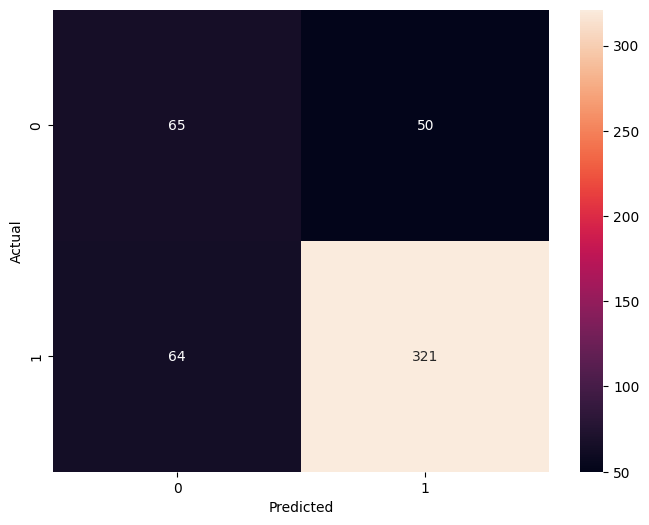

In [176]:
# confusion matrix
from nltk.metrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix

# get the predictions
predictions = classifier.classify_many([x[0] for x in test_set])

# create a confusion matrix
cm = ConfusionMatrix([x[1] for x in test_set], predictions)
print(cm)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix([x[1] for x in test_set], predictions), annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [180]:
# Custom Function to get Top Labels for each class
def most_informative_features_by_label(classifier, n=10):
    '''
    This function prints the most informative features for each label in the classifier.
    '''
    # Iterate over each unique label in the classifier
    for unique_label in list(set(classifier._labels)):
        
        # Determine the most relevant features, and display them.
        cpdist = classifier._feature_probdist
        print(f"Most Informative Features for {unique_label}:\n")
        ctr=1 # Counter
        # Iterate over the most informative features
        for (fname, fval) in classifier.most_informative_features(100000000):
            def labelprob(l):
                return cpdist[l, fname].prob(fval)
            # Sort the labels based on the probability of the feature value
            labels = sorted(
                (l for l in classifier._labels if fval in cpdist[l, fname].samples()),
                key=lambda element: (-labelprob(element), element),
                reverse=True,
            )
            l0 = labels[0]
            l1 = labels[-1]
            
            # Skip if there is only one label or if the most informative feature is for the current label
            if len(labels) == 1 or l0 == unique_label:
                continue
            # Calculate the ratio of probabilities between the two labels
            if cpdist[l0, fname].prob(fval) == 0:
                ratio = "INF"
            else:
                ratio = "%8.1f" % (
                    cpdist[l1, fname].prob(fval) / cpdist[l0, fname].prob(fval)
                )
            # Print the most informative feature and its ratio
            print(
                "%24s = %-14r %6s : %-6s = %s : 1.0"
                % (fname, fval, ("%s" % l1)[:6], ("%s" % l0)[:6], ratio)
            )
            ctr+=1
            # print(ctr)
            # Break the loop if the desired number of features has been printed
            if ctr == n:
                break

# Call the custom function with the classifier and the desired number of features
most_informative_features_by_label(classifier, n=10)

Most Informative Features for high:

               architect = 1                high : low    =     16.9 : 1.0
                 assured = 1                high : low    =     14.6 : 1.0
               architect = 2                high : low    =     14.5 : 1.0
               alignment = 1                high : low    =     12.6 : 1.0
                    rich = 1                high : low    =     12.6 : 1.0
                strategy = 4                high : low    =     12.6 : 1.0
                  global = 3                high : low    =     12.6 : 1.0
                 manages = 1                high : low    =     11.1 : 1.0
                   mrics = 1                high : low    =     10.7 : 1.0
Most Informative Features for low:

                  friday = 1                 low : high   =     12.6 : 1.0
                 enquiry = 1                 low : high   =     10.9 : 1.0
                    card = 1                 low : high   =     10.6 : 1.0
                  monday = 

## Answer
The accuracy of the model is 77.2%. 

Top 10 words that are most indicative of "high" salary:
-  architect
-  assured
-  architect
-  alignment
-  rich
-  strategy
-  global
-  manages
-  mrics

Top 10 words that are most indicative of "low" salary:
-  friday
-  enquiry
-  card
-  monday
-  rota
-  entry
-  evening
-  call
-  branch

# Q2

If I were to increae the accuracy of the model above, I would consider the following steps:
- Adding more feature to the dataset: we can also consider the length of the description, as well as other informations such as the company, position or the title of the job. 
- Improving the vectorizer: currently the implementation is only using CountVectorizer, we can either fine-tune the vectorizer or try using TF-IDF to capture different.
- Testing the features: we can perform feature selection on the dataset to keep only the most relevant features.
- Create dictionary using domaine knowledge: we can define a dictionary created by hiring experts that has domaine knowledge for highlighting some skills are highly demanding.
- Using N-Gram: we can use n-gram to capture more information, both within the phrase and on the context.
- Using different Naive Bayes rule: I used Naive Bayes from nltk, which gives Bernoulli implementation. We can experiment the multinomial version of the Naive Bayes.


## Example of fine-tuning

In [164]:
# fine tune the count vectorizer
vectorizer = CountVectorizer(max_features=7000, ngram_range=(1, 3), min_df=0.01, max_df=0.99)

# fit and transform the data
X_tuned = vectorizer.fit_transform(data['FullDescription']).toarray()

# create a DataFrame from the document-term matrix
X_tuned = pd.DataFrame(X_tuned, columns=vectorizer.get_feature_names_out())

# check the DataFrame
X_tuned

,ability,ability build,ability communicate,ability manage,ability work,able,able demonstrate,able provide,able work,absence,...,www salestarget co,www totaljobs,www totaljobs com,xml,year,year experience,yet,yorkshire,young,young people
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2496,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
2497,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
# add length of the job description as a feature
X_tuned['description_length'] = data['FullDescription'].apply(len)

In [166]:
# split the data
X_train_tuned, X_test_tuned, y_train_tuned, y_test_tuned = train_test_split(X_tuned, data['SalaryLevel'], test_size=0.2, random_state=42)

# combine the features and labels
training_set_tuned = combine_features_and_labels(X_train_tuned, y_train_tuned)
test_set_tuned = combine_features_and_labels(X_test_tuned, y_test_tuned)


In [167]:
# train the classifier
classifier_tuned = NaiveBayesClassifier.train(training_set_tuned)

# check the accuracy of the classifier
print("Model accuracy is: ",accuracy(classifier_tuned, test_set_tuned))

Model accuracy is:  0.778


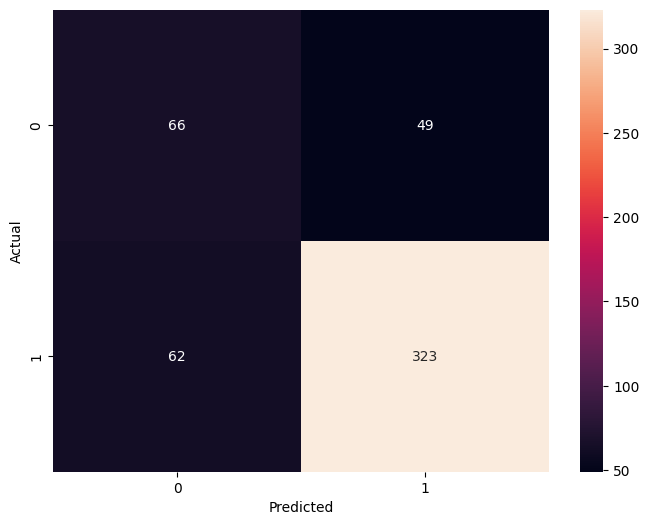

In [181]:
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix([x[1] for x in test_set_tuned], classifier_tuned.classify_many([x[0] for x in test_set_tuned])), annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We can observe a slight performance increase by 0.6%.